# Task 2
# Kalman filter

## System description

Consider a model of horizontal movement of a surface vessel. Let us assume that the thrust force compensates for the longitudinal hydrodynamic resistance and the motion occurs at a constant speed $V_0 = V_x = const$.



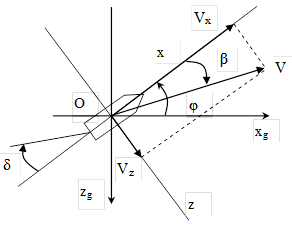

In [6]:
%matplotlib inline
from IPython.display import Image
Image('model.png', width=500)

The motion dynamics can be described by the following system of equations:

$$
\left[
    \begin{array}{c}
        \dot{\varphi} \\
        \dot{\omega} \\
        \dot{V}
    \end{array}
\right] = 

\left[
    \begin{array}{ccc}
        0 & 1 & 0 \\
        0 & a_{22} & a_{23}/V_0 \\
        0 & a_{32}V_0 & a_{33}
    \end{array}
\right] 
\left[
    \begin{array}{c}
        \varphi \\
        \omega \\
        V
    \end{array}
\right] +

\left[
    \begin{array}{c}
        0 \\
        b_{21} \\
        b_{31}
    \end{array}
\right] \delta
$$

where $\phi$ is a vessel's heading direction, $\omega$ is a vessel's angular velocity, $V_z$ is a vessel's transverse speed, $\delta$ is vessel's rudder angle,
$a_{22}=-328$,  $a_{23}=2060$, $a_{32}=0.58$, $a_{33}=-5150$, $b_{21}=1$, $b_{31}=18$  are constants.

The heading direction of the vessel is available for measurement with an error with a normal distribution and zero mean. The deviation of the model from the vessel is also described by a normal distribution with zero mean.

## Task

1. Definre vessel parameters.
2. Define model variances (heading direction, angular velocity and transverse velocity) and sensor variance.
3. Model the vessel's trajectory for 4 different rudder angles.
4. Build a Kalman filter to assess the state of the vessel.
5. Plot graphs of measurement and estimates of state variables.
6. Get formulas for determining the global coordinates of the vessel from state variables.
7. Plot the vessel's trajectory, its measurement and estimates.

1. Define vessel parameters

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# a22=-3
# a23=2
# a32=0.58
# a33=-5
# b21=1
# b31=18
# v0=10
# A = np.array([[0,1,0], [0, a22, a23/v0], [0, a32*v0, a33]])
# B = np.array([[0, b21, b31]]).T
# x = [0, 0, 0.1]
# dt = 0.1
# A,B

(array([[ 0. ,  1. ,  0. ],
        [ 0. , -3. ,  0.2],
        [ 0. ,  5.8, -5. ]]),
 array([[ 0],
        [ 1],
        [18]]))

2. Define model variances

3. Trajectory for 4 different rudder angles

In [264]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List


class state_space:
    def __init__(self, A,B, C,dt):
        self.A = A
        self.B = B
        self.C = C
        self.dt = dt #sampling
        
    def run(self, x,u, Noise = None):
        if Noise is None:
            Noise = np.zeros_like(self.B)
        x_dot = self.A@x + self.B*u + Noise
        y =x+ x_dot*self.dt
        return y


class Vessel():
    #noise variances
    s_th = 0.08
    s_w = 0.3
    s_v = 0.2
    s_m = 0.1
    dt=0.1 #sampling
    def __init__(self,A=None,B=None):
        if A is None:
            v0=10
            self.v0 = v0
            A = np.array([[0,1,0], [0, -3,2/v0], [0,0.58*v0,-5]])
        if B is None:
            B = np.array([[0,1,18]]).T
        C = np.array([[1,0,0]])
        self.model = state_space(A,B,C,Vessel.dt)
        self.cache = {
            'x':[np.zeros((3,1))],
            'x_r':[np.zeros((3,1))],
            'pt':(0,0),
            'pt_r':(0,0),
            'angle':0,
            'angle_r':0,
        }
        self.history = {
            'pt':[],
            'pt_r':[],
            'th':[],
            'w':[],
            'v':[],
            'th_r':[],
            'w_r':[],
            'v_r':[],
        }

    def loop(self,t:List,u:List):
        for interval, u_step in zip(t,u):
            self.one_loop(interval, u_step)

    def one_loop(self,t, u):
        for i in np.arange(0,t, Vessel.dt):
            x,x_r,pt,pt_r,angle,angle_r = self.unpack_cache()
            Noise = self._state_noise()
            x = self.model.run(x,u,Noise)
            x_r = self.model.run(x_r,u)
            angle_r = self.actual_angle(x_r)
            angle = self.measure_angle(x_r)
            pt = self.calc_xy(x,pt,angle)
            pt_r = self.calc_xy(x_r, pt_r, angle_r)
            self.update(x,x_r, pt, pt_r, angle, angle_r)
            w = x[1]
            v = x[2]
            w_r = x_r[1]
            v_r = x_r[2]
            self.update_history(pt,pt_r,angle,angle_r,w,w_r,v,v_r)

    def unpack_cache(self):
        return self.cache['x'][0], self.cache['x_r'][0],self.cache['pt'], self.cache['pt_r'], self.cache['angle'],self.cache['angle_r'],
    
    def step_with_noise(self,x,u):
        x_1 = np.matmul(Vessel.A, x) + Vessel.B*u + self._state_noise()
        x =x+ x_1*Vessel.dt
        return x
        
    def _state_noise(self):
        return np.array([[np.random.normal(0, Vessel.s_th),np.random.normal(0, Vessel.s_w), np.random.normal(0, Vessel.s_v)]]).T
    
    def step_real(self,x_r,u):
        x_0 = np.matmul(Vessel.A, x_r) + Vessel.B*u
        x_r =x_r+ x_0*Vessel.dt
        return x_r
    
    def measure_angle(self, x_r):
        fi_n= x_r[0][0]+ np.random.normal(0, Vessel.s_m)
        return fi_n
    
    def actual_angle(self,x_r):
        fi_r=x_r[0][0]
        return fi_r
    
    def calc_xy(self,x_state,pt,fi):
        x,y = pt
        v = x_state[2][0]
        cosB = v/self.v0
        beta = np.arccos(cosB)
        x += v*Vessel.dt*np.cos(fi-beta) 
        y += v*Vessel.dt*np.sin(fi-beta) 
        return (x,y)
    
    def update(self,x,x_r, pt, pt_r, angle, angle_r):
        self.cache['x'] = [x]
        self.cache['x_r'] = [x_r]
        self.cache['pt'] = pt
        self.cache['pt_r'] = pt_r
        self.cache['angle'] = angle
        self.cache['angle_r'] = angle_r

    def update_history(self,pt,pt_r,th,th_r,w,w_r,v,v_r):
        self.history['pt'].append(pt)
        self.history['pt_r'].append(pt_r)
        self.history['th'].append(th)
        self.history['th_r'].append(th_r)
        self.history['w'].append(w)
        self.history['w_r'].append(w_r)
        self.history['v'].append(v)
        self.history['v_r'].append(v_r)
    
    def read_history_pt(self,points):
        x,y = [],[]
        for pt in points:
            x_temp, y_temp = pt
            x.append(x_temp)
            y.append(y_temp)
        return x,y

    def read_history(self):
        x,y,x_r,y_r = [],[],[],[]
        x,y = self.read_history_pt(self.history['pt'])
        x_r, y_r = self.read_history_pt(self.history['pt_r'])
        return x,y,x_r,y_r
    
    def plot_pos(self):
        x,y,x_r,y_r = self.read_history()
        fig, ax = plt.subplots()
        ax.set_title("Trajectory of the vessel")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.plot(x,y, 'b')
        ax.plot(x_r,y_r, 'g')
    def plot(self,key = 'v'):
        param = self.history[key]
        param_r = self.history[key+"_r"]
        t = np.arange(0,int(len(param)*Vessel.dt),Vessel.dt)
        plt.plot(t,param, 'b')
        plt.plot(t,param_r, 'g')
        plt.title(key)
    def plot_all(self):
        plt.figure()
        plt.subplot(1,3,1)
        self.plot('th')
        plt.subplot(1,3,2)
        self.plot('v')
        plt.subplot(1,3,3)
        self.plot('w')

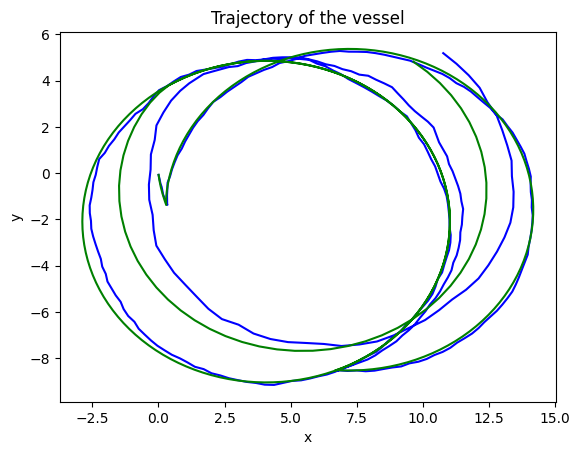

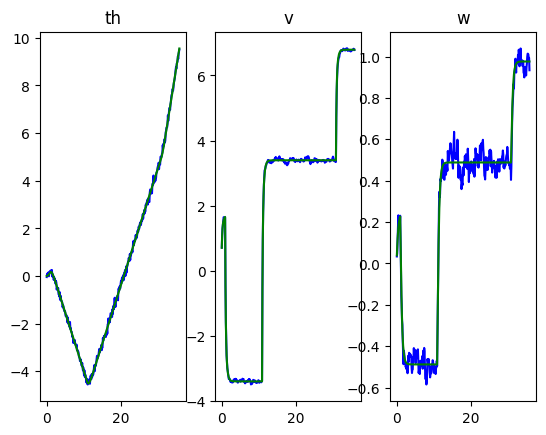

In [269]:
u = [np.pi/8, -np.pi/4, np.pi/4, np.pi/4, np.pi/2]
t = np.array([1, 10, 5,15,5])
model = Vessel()
model.loop(t,u)
model.plot_pos()
model.plot_all()

Simpler case: Only one rudder angle

In [ ]:
s_th = 0.03
s_w = 0.01
s_v = 0.01
s_m = 0.03

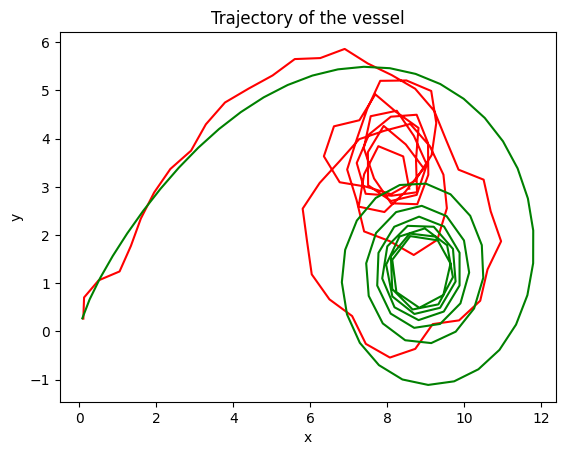

In [237]:
import matplotlib.pyplot as plt
from scipy import integrate




s_th = 0.3
s_w = 0.5
s_v = 0.5
s_m = 0.3

def model(N,x, x_r, u):
    
    th = []
    th_r = []
    w = []
    v = []
    xx = []
    yy = []
    xx_r = []
    yy_r = []
    xx_m = []
    yy_m = []
    posx = 0
    posy = 0
    posx_r = 0
    posy_r = 0
    a22=-3
    a23=2
    a32=0.58
    a33=-5
    b21=1
    b31=18
    v0=10

    A = np.array([[0,1,0], [0, a22,a23/v0], [0,a32*v0,a33]])
    B = np.array([0,b21,b31])
    C = np.array([[1, 0,0]])
    
    dt = 0.1
    # A=np.eye(3)+A*dt
    # B=B*dt
    fi_r = 0
    fi_n = 0
    for i in np.arange(0,N, dt):
        noise = np.array([np.random.normal(0, s_th),np.random.normal(0, s_w), np.random.normal(0, s_v)])

        x_0 = np.matmul(A, x_r) + B*u
        x_r =x_r+ x_0*dt
        x_1 = np.matmul(A, x) + B*u + noise
        x =x+ x_1*dt

        fi_r+=x_r[0]*dt
        fi_r = fi_r%(2*np.pi)
        fi_n= fi_r + x_r[0]*dt+ np.random.normal(0, s_m)
        fi_n = fi_n%(2*np.pi)
        th.append(fi_n)
        th_r.append(fi_r)
        w.append(x[0])
        v.append(x[1])

        vv = x[2]
        cosB = vv/v0
        beta = np.arccos(cosB)
        posx +=vv*dt*np.cos(fi_n-beta) 
        posy +=vv*dt*np.sin(fi_n-beta) 

        vv = x_r[2]
        cosB = vv/v0
        beta = np.arccos(cosB)
        posx_r +=vv*dt*np.cos(fi_r-beta)
        posy_r +=vv*dt*np.sin(fi_r-beta)
        
        xx.append(posx)
        yy.append(posy)
        xx_r.append(posx_r)
        yy_r.append(posy_r)

    return th, th_r,w,v, xx, yy, xx_r, yy_r, x, x_r

def show(th,w,v):
    l = len(th)
    plt.figure(figsize = (20,5))
    plt.subplot(1,3,1)
    plt.title("Theta")
    plt.plot(np.arange(0,l)*dt, th)

    plt.subplot(1,3,2)
    plt.title("w")
    plt.plot(np.arange(0,l)*dt, w)

    plt.subplot(1,3,3)
    plt.title("v")
    plt.plot(np.arange(0, l)*dt, v)

def plotxy(ax, x,y,c = 'b'):
    
    ax.plot(x,y, c)
    ax.set_title("Trajectory of the vessel")
    ax.set_xlabel("x")
    ax.set_ylabel("y")




u = [-np.pi/2, -np.pi/4, np.pi/4, np.pi/2]
ts = np.array([15, 5, 5, 15])

t = 0
N = 15
dt = 0.1

xx_all = []
yy_all = []
th_all = []
th_r_all = []
w_all = []
v_all = []
xx_r_all = []
yy_r_all = []
x = np.array([0,0,0])
x_r = np.array([0,0,0])

th,th_r, w,v,xx,yy, xx_r, yy_r, state, state_r = model(10,x,x_r, u[0])


fig, ax = plt.subplots()

plotxy(ax, xx,yy, 'red')
plotxy(ax, xx_r,yy_r, 'green')

In [226]:
np.random.normal(0, 0.3)

-0.09685034064663384

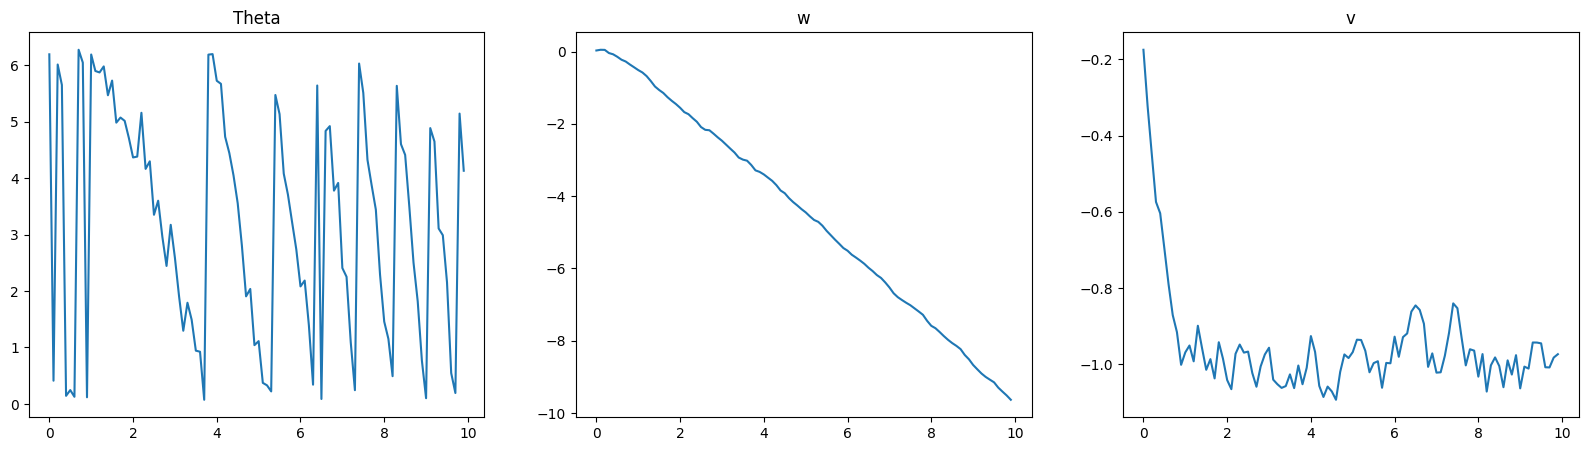

In [238]:
show(th,w,v)

Kalman filter

In [239]:
a22=-3
a23=2
a32=0.58
a33=-5
b21=1
b31=18
v0=10

A = np.array([[0,1,0], [0, a22,a23/v0], [0,a32*v0,a33]])
A = np.eye(3)+A*dt
B = np.array([[0],[b21],[b31]])
B = B*dt
C = np.array([[1, 0,0]])


sigma_z = s_m
Ez = sigma_z**2
accel_noise_mag = 0.02 # acceleration measurement error
Ex = accel_noise_mag*np.array([[s_th*dt**2, s_w*s_v*dt**2, s_th*s_v*dt**2], [s_w*s_th*dt**2, s_w*s_w*dt**2, s_w*s_v*dt**2],[s_th*s_v*dt**2,s_w*s_v*dt**2,s_v*s_v*dt**2]])

p_est = []
v_est = []
x = np.array([[0],[0],[0]])
Sigma = Ex.copy() # initial covariance
fi_r = 0
posx = 0
posy = 0
all_x = []
all_y = []
for i in range(len(th_r)):

    x_pred = np.matmul(A, x) + B*u[0]
    Sigma_pred = np.matmul(np.matmul(A, Sigma), A.T)# + Ex

    Sigma_pred = A@Sigma@A.T
    C@Sigma_pred@C.T+Ez
    
    temp = np.matmul(C, Sigma_pred)
    temp = np.matmul(temp, C.T)
    temp = temp + Ez

    temp = np.linalg.inv( temp)
    temp = np.matmul(C.T, temp)   
    K = np.matmul(Sigma_pred, temp)
    
    x = x_pred + K* ( th_r[i] - np.matmul(A, x_pred))
    p_est.append(x[0][0])
    v_est.append(x[2][0])
    
    temp = np.eye(3) - np.matmul(K, C)
    Sigma = np.matmul(temp, Sigma_pred)

    fi_r+=x[0][0]*dt
    vv = x[2][0]
    cosB = vv/v0
    beta = np.arccos(cosB)
    posx +=vv*dt*np.cos(fi_r-beta) 
    posy +=vv*dt*np.sin(fi_r-beta) 
    all_x.append(posx)
    all_y.append(posy)
    

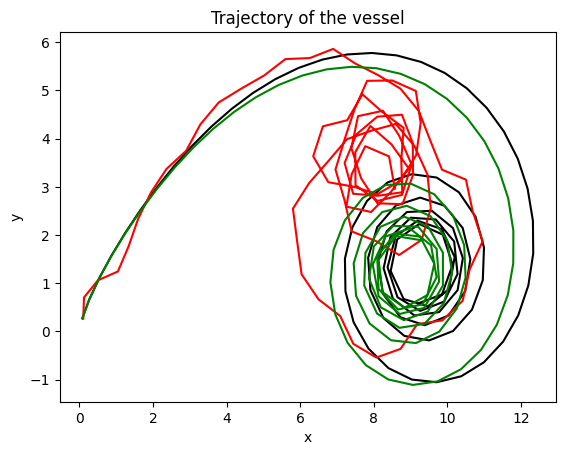

In [240]:
fig, ax = plt.subplots()
plotxy(ax, all_x, all_y, 'black')
plotxy(ax, xx,yy, 'red')
plotxy(ax, xx_r,yy_r, 'green')